In [9]:
#@title Import { display-mode: "form" }

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()

import tensorflow_probability as tfp

from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path


sns.reset_defaults()
#sns.set_style('whitegrid')
#sns.set_context('talk')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tf.keras.backend.set_floatx('float64')              

tfd = tfp.distributions

In [11]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return 10 * np.sin(2 * np.pi * (x)) + epsilon

#def f(x, sigma):
#    epsilon = np.random.randn(*x.shape) * sigma
#    return x + 0.3*np.sin(2*np.pi*(x+epsilon))+ 0.3*np.sin(4*np.pi*(x+epsilon)) +epsilon

train_size = 100
noise = 0.1

X = np.linspace(-0.5, 0.5, train_size).reshape(-1, 1)
y = f(X, sigma=noise)

batch_size = train_size

def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
  ])

#def prior_trainable(kernel_size, bias_size=0, dtype=None):
#  n = kernel_size + bias_size
#  c = np.log(np.expm1(1.))
#  return tf.keras.Sequential([
#      tfp.layers.VariableLayer(2 * n, dtype=dtype),
#      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
#          tfd.Normal(loc=t[..., :n], 
#                     scale=1e-5 + tf.nn.softplus(c + t[..., n:]) ),
#          reinterpreted_batch_ndims=1)),
#  ])

def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n], scale=1.0 ),
            reinterpreted_batch_ndims=1)),
  ])
# Build model.
model = tf.keras.Sequential([
    tfp.layers.DenseVariational(20, posterior_mean_field, prior_trainable, 
                                kl_weight=1/X.shape[0],
                              activation='relu'),
    tfp.layers.DenseVariational(20, posterior_mean_field, prior_trainable, 
                                kl_weight=1/X.shape[0],
                              activation='relu'),
    tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable,
                               kl_weight=1/X.shape[0]),
    tfp.layers.DistributionLambda(
      lambda t: tfd.Independent(tfd.Normal(loc=t[..., :1], scale=1.0 ),
          reinterpreted_batch_ndims=1))  
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)

model.fit(X, y,batch_size=4, epochs=550, verbose=False);

# Profit.
#[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(X)
assert isinstance(yhat, tfd.Distribution)

In [12]:
# sampling output 

X_test = np.linspace(-1.0, 1.0, 1000).reshape(-1, 1)

y_pred_list=[]
yhats = [model(X_test) for _ in range(200)]

for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    y_pred_list.append(m)

y_preds=np.array(y_pred_list)
y_mean = np.mean(y_preds, axis=0)
y_sigma = np.std(y_preds, axis=0)

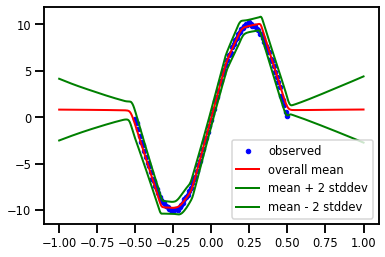

In [13]:
plt.plot(X, y, 'b.', label='observed');
plt.plot(X_test, y_mean , 'r', linewidth=2, label=r'overall mean ');
plt.plot(X_test, y_mean + 2 * y_sigma, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(X_test, y_mean - 2 * y_sigma, 'g', linewidth=2, label=r'mean - 2 stddev');
#for _ in range(3):
#    plt.plot(X_test,y_preds[_,:],'y')
plt.legend()